In [18]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import sys
sys.path.append('..')
from utils import *
from networks import *

In [19]:
import matplotlib.pyplot as plt
import scienceplots
import cmasher as cmr
plt.style.use('science')
cmap_pred = plt.get_cmap('cmr.wildfire')
cmap_error = plt.get_cmap('cmr.cosmic')

In [3]:
problem = "advection"
hino_or_hno = "HNO"
running_on = "local"
if running_on == "local":
    data_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/data/"
    checkpoint_path = "C:/Users/eirik/orbax/checkpoints/"
else:
    data_path = "/cluster/work/eirikaf/data/"
    checkpoint_path = "/cluster/work/eirikaf/checkpoints/"

In [4]:
data = jnp.load(data_path + problem + ".npz")
train_val_test = train_val_test_split(data["data"], 0.8, 0.1, 0.1)
scaled_data = jnp.load(data_path + problem + "_scaled_data.npz")

In [5]:
u_standardizer = GaussianStandardizer(train_val_test["train"])
x_standardizer = MinMaxStandardizer(data["x"], min = 0, max=20)
t_standardizer = MinMaxStandardizer(data["t"], min = 0, max=2)

In [6]:
a_train_s = scaled_data["a_train_s"]
u_train_s = scaled_data["u_train_s"]
a_val_s = scaled_data["a_val_s"]
u_val_s = scaled_data["u_val_s"]
a_test_s = scaled_data["a_test_s"]
u_test_s = scaled_data["u_test_s"]

x_train_s = scaled_data["x_train_s"]
t_train_s = scaled_data["t_train_s"]

x_test_s = scaled_data["x_test_s"] 
t_test_s = scaled_data["t_test_s"]

x_test = x_standardizer.decode(x_test_s)
t_test = t_standardizer.decode(t_test_s)

u_test = u_standardizer.decode(u_test_s)

In [7]:
networks = {
    "deeponet": HNO_DON,
    #"modified_deeponet": ModifiedDeepONet,
    #"fno_timestepping": FNOTimeStepping,
    #"fno1d": FNO1d,
    #"fno2d": FNO2d
}
models = {}
trainers = {}

for network_name, network in networks.items():
    trainers[network_name] = Trainer.from_checkpoint(checkpoint_path + f"{network_name}_{problem}_{hino_or_hno}", 
                                                 network)
    models[network_name] = trainers[network_name].model

In [9]:
pretty_names = {
    "deeponet": hino_or_hno + "DeepONet",
    "modified_deeponet": hino_or_hno + "ModifiedDeepONet",
    "fno_timestepping": hino_or_hno + "FNOTimeStepping",
    "fno1d": hino_or_hno + "FNO1d",
    "fno2d": hino_or_hno + "FNO2d"
}

### Plot one prediction from the test set for t = 0, t $\approx$ 1, t $\approx$ 2, t $\approx$ 3

In [14]:
sample_idx = 88

u_preds = {}
for network_name, model in models.items():
    if network_name == "fno_timestepping":
        u_preds[network_name] = u_standardizer.decode(model.predict_whole_grid(a_test_s[sample_idx], x_test_s, t_test_s))
    else:
        t = t_test_s[t_test_s < 1] # time interval [0, 2) (use scaled time as input to model, hence t_test_s < 1)
        # prediction on [0, 2)
        u_pred1 = u_standardizer.decode(model.predict_whole_grid(a_test_s[sample_idx], x_test_s, t))
        # prediction on [1, 3) by using the prediction for t=1 as initial condition 
        u_pred2 = u_standardizer.decode(model.predict_whole_grid(u_pred1[t==0.5][0], x_test_s, t))
        
        # concatenate the predictions on [0, 2) and [2, 3)
        u_preds[network_name] = jnp.concatenate((u_pred1, u_pred2[t>=0.5]), axis=0)

u_gt = u_test[sample_idx]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

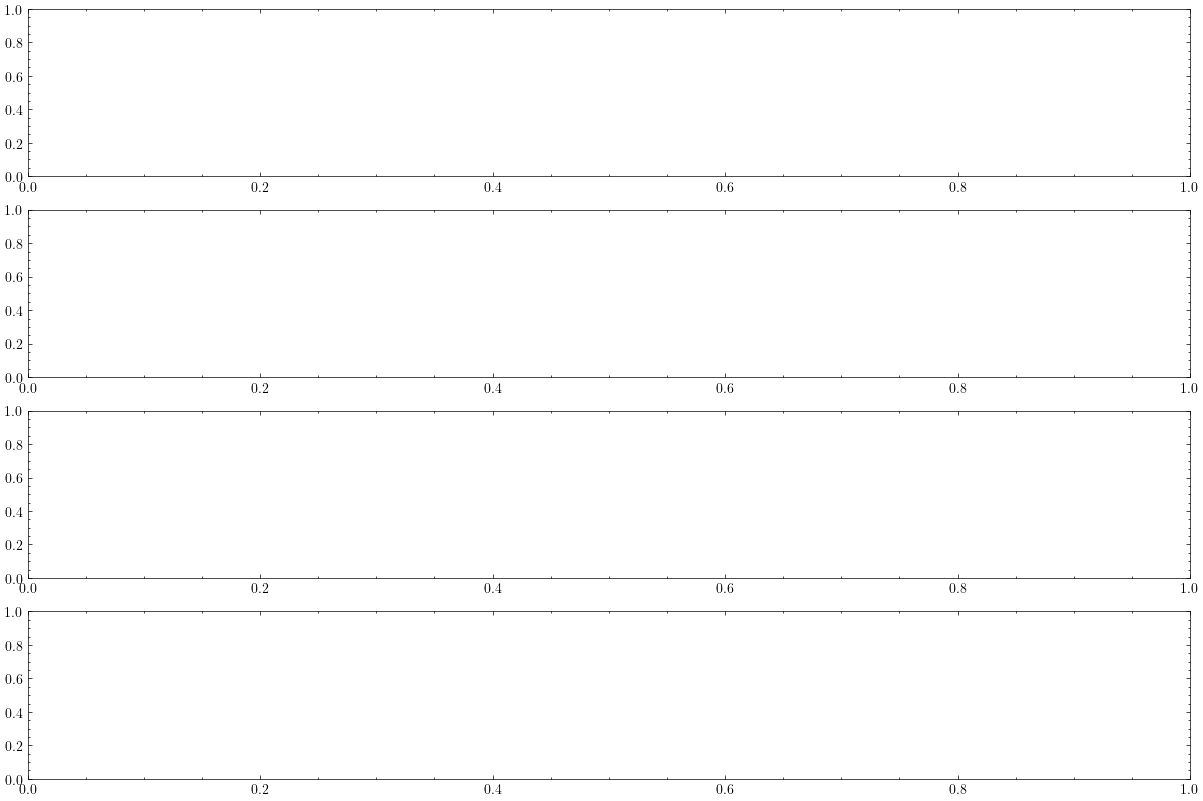

In [15]:
pred_color = "#7ab368"

time_indices = [0, jnp.where(t_test == 1)[0][0], jnp.where(t_test < 2)[0][-1], -1]
time_labels = [f't={t_test[time_indices[0]]:.2f}', f't={t_test[time_indices[1]]:.2f}', f't={t_test[time_indices[2]]:.2f}', f't={t_test[time_indices[3]]:.2f}']

fig, axes = plt.subplots(len(time_indices), len(u_preds), figsize=(15, 10))

y_min, y_max = u_gt.min(), u_gt.max()
for i, time_idx in enumerate(time_indices):
    for j, (model_name, u_pred) in enumerate(u_preds.items()):
        ax = axes[i, j]
        ax.plot(x_test, u_gt[time_idx, :], 'k--', label='Ground Truth')
        ax.plot(x_test, u_pred[time_idx, :], color=pred_color, label='Prediction')
        ax.set_ylim(y_min, y_max)  # Set the y-axis limits
        if i == 0:
            ax.set_title(pretty_names[model_name], fontsize=14)
        if j == 0:
            ax.set_ylabel(time_labels[i], fontsize=14)
        ax.tick_params(top=False,
                       left=False,
                       right=False, 
                       bottom=False, 
                       labelleft=False, 
                       labelbottom=False, 
                       which='both')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Create a common legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.), fontsize='large')

# Add a title to the figure
fig.suptitle('Predictions on unseen initial condition for the advection equation', fontsize=18, x=0.5, y=1.05)

# Adjust space between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.3)

plt.savefig("predictions/pred_advection.svg")
plt.show()

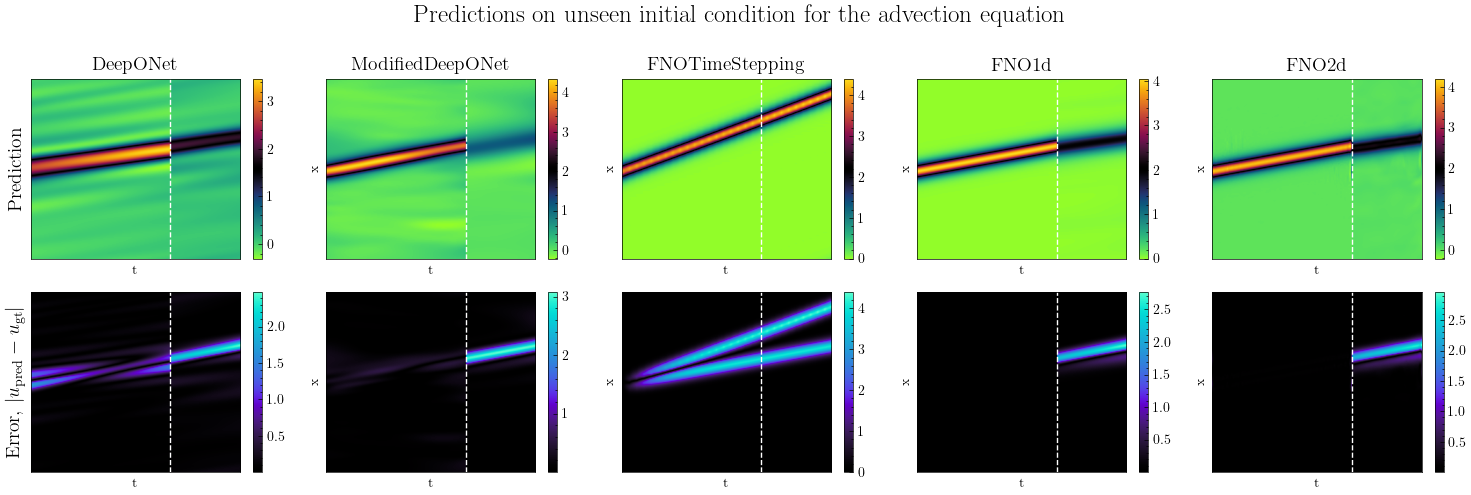

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

for i, (model_name, u_pred) in enumerate(u_preds.items()):
    # First row: imshow of u_pred
    ax1 = axes[0, i]
    im1 = ax1.imshow(u_pred.T, aspect='auto', cmap=cmap_pred, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower')
    ax1.set_title(pretty_names[model_name], fontsize=14)
    fig.colorbar(im1, ax=ax1)
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.axvline(x=2, color='white', linestyle='--')  # Add dashed line for t_test == 2
    ax1.tick_params(
                top=False,
                right=False, 
                bottom=False, 
                left=False,
                labelleft=False, 
                labelbottom=False, 
                which='both')
    
    # Second row: imshow of u_pred - u_gt
    ax2 = axes[1, i]
    im2 = ax2.imshow(jnp.abs(u_pred - u_gt).T, aspect='auto', cmap=cmap_error, extent=[t_test.min(), t_test.max(), x_test.min(), x_test.max()], origin='lower')
    fig.colorbar(im2, ax=ax2)
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    ax2.axvline(x=2, color='white', linestyle='--')
    ax2.tick_params(
            top=False,
            right=False, 
            bottom=False, 
            left=False,
            labelleft=False, 
            labelbottom=False, 
            which='both')

axes[0, 0].set_ylabel('Prediction', fontsize=14)
axes[1, 0].set_ylabel(r'Error, $|u_{\text{pred}} - u_{\text{gt}}|$', fontsize=14)

fig.suptitle('Predictions on unseen initial condition for the advection equation', fontsize=18, x=0.5, y=1)

plt.tight_layout()
plt.savefig("predictions/pred_advection_imshow.svg")
plt.show()

In [16]:
jnp.mean(trainers["deeponet"].λ_history[0])

Array(1.96117591, dtype=float64)

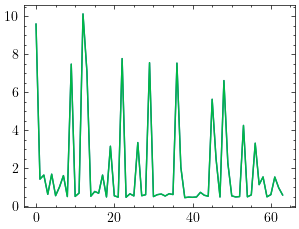

In [17]:
plt.plot(trainers["deeponet"].λ_history[0])
plt.plot(trainers["deeponet"].λ_history[-1])

# Loss plot

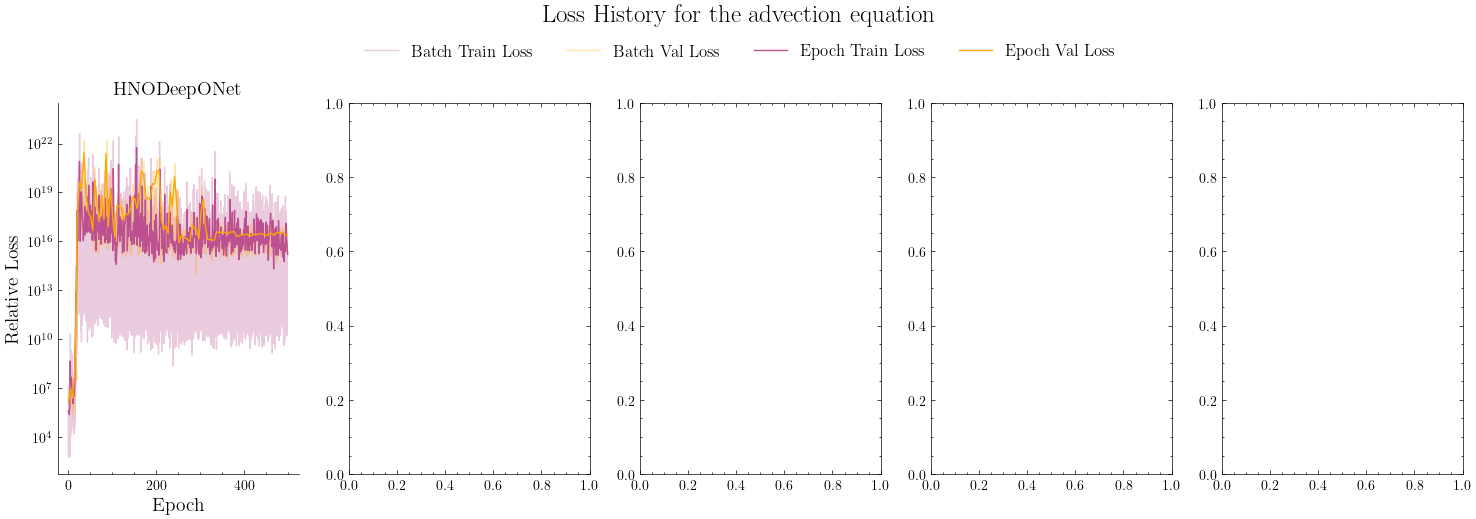

In [10]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
methods = list(trainers.keys())
train_color = '#bc5090'
val_color = '#ffa600'

for i, (model_name, trainer) in enumerate(trainers.items()):
        ax = axes[i]
        
        # Plot batch loss
        ax.plot(jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.train_loss_history_batch)),
                trainer.train_loss_history_batch, color=train_color, alpha=0.3, label='Batch Train Loss')
        ax.plot(jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.val_loss_history_batch)),
                trainer.val_loss_history_batch, color=val_color, alpha=0.3, label='Batch Val Loss')
        
        # Plot epoch loss
        ax.plot(jnp.arange(len(trainer.train_loss_history)), trainer.train_loss_history, 
                color=train_color, label='Epoch Train Loss')
        ax.plot(jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.val_loss_history)), 
                trainer.val_loss_history, 
                color=val_color, label='Epoch Val Loss')
        
        ax.set_title(pretty_names[model_name], fontsize=14)
        ax.set_xlabel('Epoch', fontsize=14)
        ax.set_yscale('log')
        ax.tick_params(
                top=False,
                right=False, 
                which='both')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
axes[0].set_ylabel('Relative Loss', fontsize=14)   

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.), fontsize='large')

fig.suptitle('Loss History for the advection equation', fontsize=18, x=0.5, y=1.05)
plt.tight_layout()
#plt.savefig("loss/loss_kdv.svg")
plt.show()

# Table with performance information

In [20]:
def test_relative_error(u_pred, u_test):    
    batch_size = u_test.shape[0] 
    u_norms = jnp.linalg.norm(u_test.reshape(batch_size,-1), 2, 1)
    diff_norms = jnp.linalg.norm((u_test - u_pred).reshape(batch_size,-1), 2, 1)
        
    loss = jnp.mean(diff_norms/u_norms)
    return loss

def test_mse(u_pred, u_test):    
    #compute the mse
    mse = jnp.mean((u_test - u_pred)**2)
    return mse

In [ ]:
# Initialize lists to store the results
method_names = []
param_counts = []
times_per_epoch = []
epochs_trained = []
relative_errors = []
mses = []

t = t_test_s[t_test_s < 1]
u_test_without_extrapolation = u_test[:,t_test_s < 1]
# Iterate over each method and compute the required metrics
for method_name, trainer in trainers.items():    
    model = models[method_name]
    method_names.append(pretty_names[method_name])
    param_counts.append(param_count(model))
    times_per_epoch.append(trainer.time_trained / trainer.epochs_trained)
    epochs_trained.append(trainer.epochs_trained)
    
    u_pred = u_standardizer.decode(vmap(eqx.filter_jit(model.predict_whole_grid), (0, None, None))(a_test_s, x_test_s, t))
    relative_errors.append(test_relative_error(u_pred, u_test_without_extrapolation))
    mses.append(test_mse(u_pred, u_test_without_extrapolation))

# Create a pandas dataframe to store the results
results_df = pd.DataFrame({
    'Method': method_names,
    '# Parameters': param_counts,
    'Time per Epoch (s)': times_per_epoch,
    'Epochs Trained': epochs_trained,
    'Relative Error': relative_errors,
    'MSE': mses
})

results_df.to_csv("performance_metrics/performance_metrics_kdv.csv", index=False)